In [1]:
#REading a .fif file with MNE
import warnings
warnings.filterwarnings('ignore')
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity import vector_auto_regression

In [6]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/Pat28_seizure_segment_raw.fif')

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/Pat28_seizure_segment_raw.fif...
Isotrak not found
    Range : 6448128 ... 7062528 =   6297.000 ...  6897.000 secs
Ready.


In [7]:
print(raw)
print(raw.info)

<Raw | Pat28_seizure_segment_raw.fif, 106 x 614401 (600.0 s), ~91 kB, data not loaded>
<Info | 9 non-empty values
 bads: []
 ch_names: EEG 000, EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
 chs: 106 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 106
 projs: []
 sfreq: 1024.0 Hz
>


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


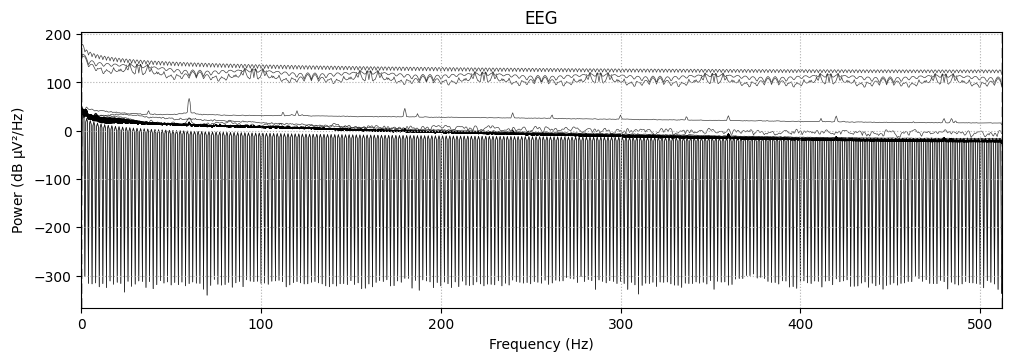

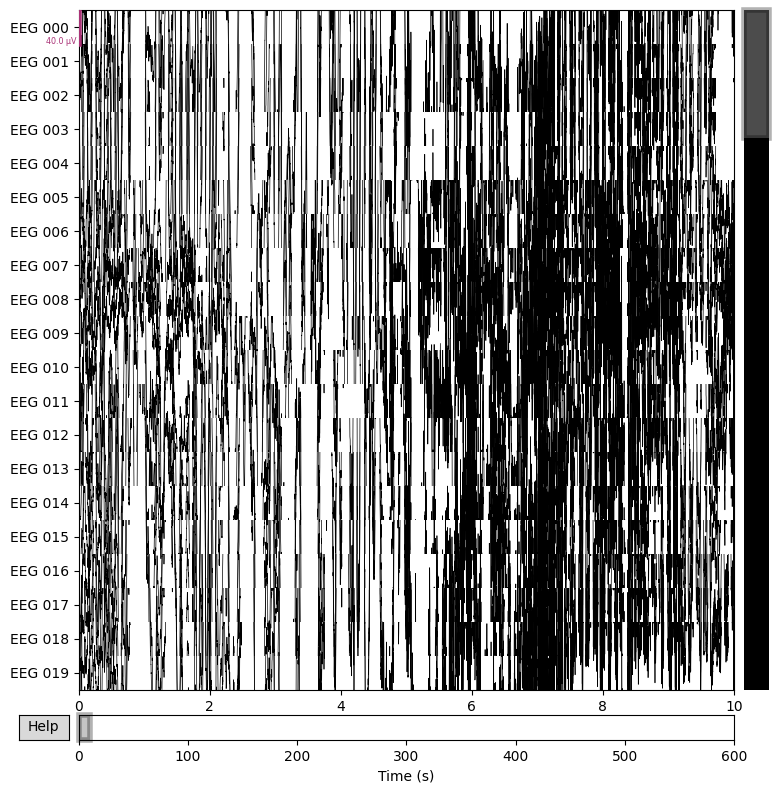

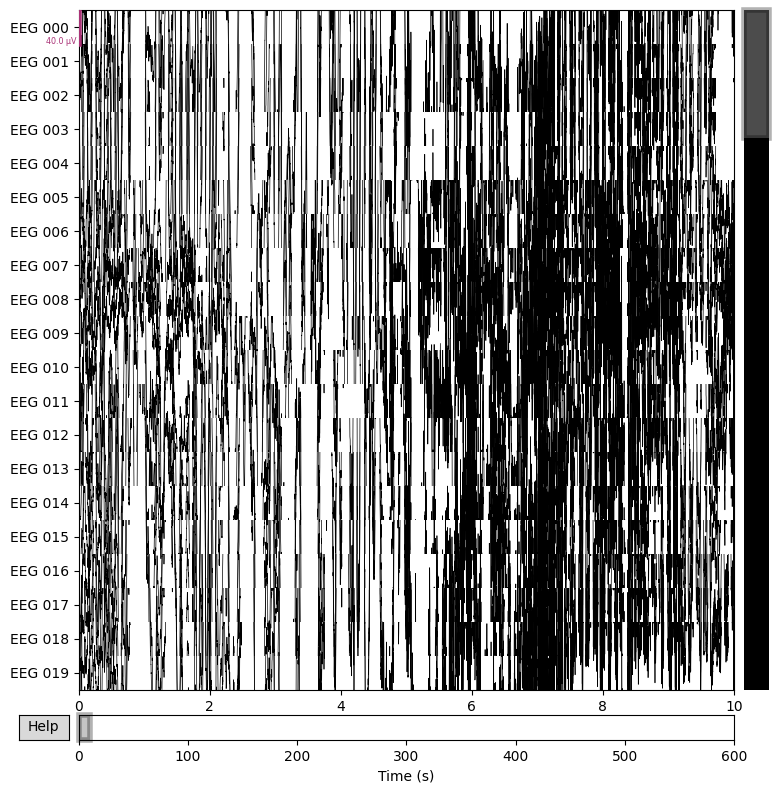

In [8]:
raw.compute_psd().plot(picks="data", exclude="bads")
raw.plot()

[ 24  41  54  63  82 102 103 104]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


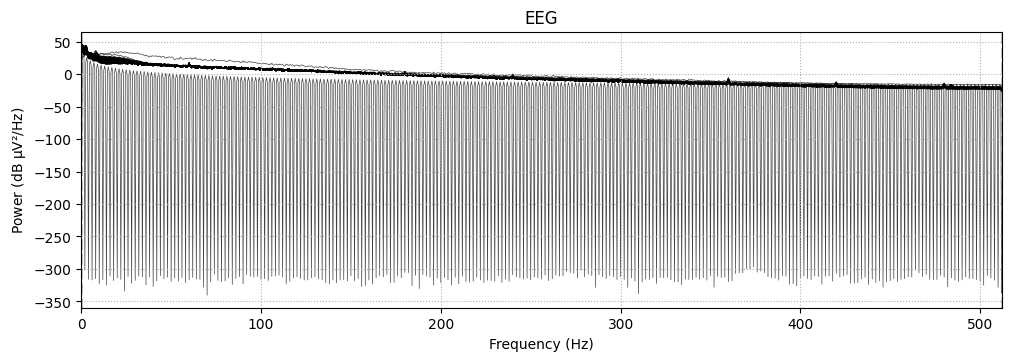

In [9]:
#Trying to detect outlier channels 
channel_variances = np.var(raw.get_data(), axis=1)
threshold = 3 * np.median(channel_variances)  # You can adjust the threshold based on your data
outlier_channels = np.where(channel_variances > threshold)[0]
print(outlier_channels)

#Plotting the PSD of the outlier channels
raw.plot_psd(picks=outlier_channels, average=False)

#Plotting the PSD of the data without the outlier channels
raw.plot_psd(picks=np.delete(np.arange(0, 105), outlier_channels), average=False)

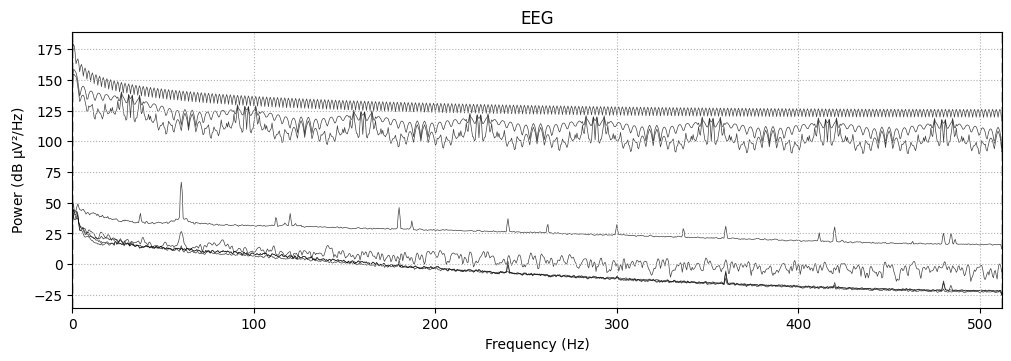

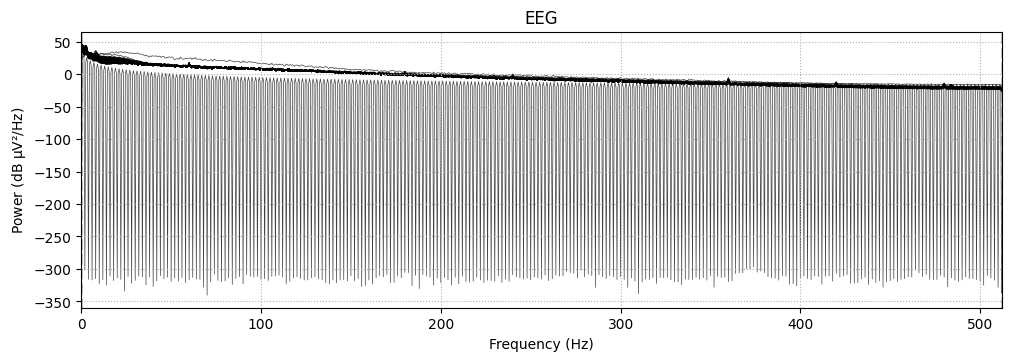

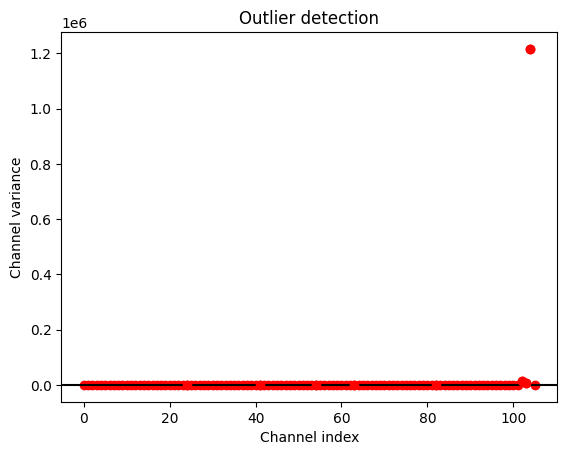

In [10]:
#Plotting outliers
fig, ax = plt.subplots()
ax.plot(channel_variances, 'ro')
ax.axhline(threshold, color='k')
ax.set(title='Outlier detection', xlabel='Channel index', ylabel='Channel variance')
ax.plot(outlier_channels, channel_variances[outlier_channels], 'r.', markersize=12)
plt.show()

[102 103 104]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


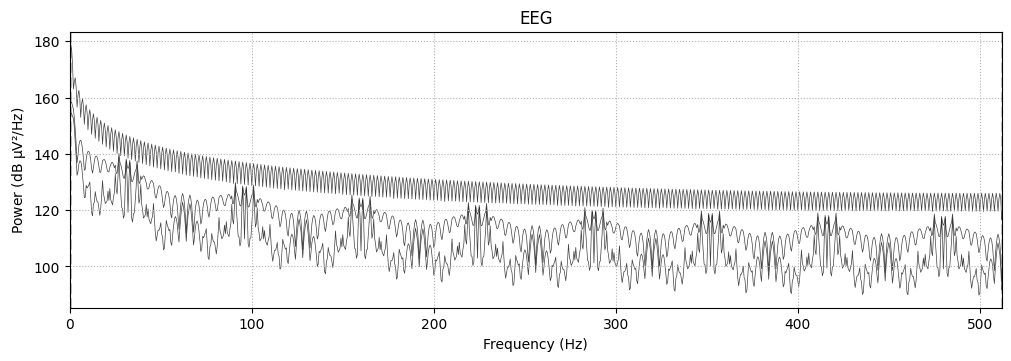

In [11]:
#Outlier detection using thresholding amplitudes
amplitude_threshold = 100  # Adjust based on your data
outlier_channels = np.where(np.max(np.abs(raw.get_data()), axis=1) > amplitude_threshold)[0]
print(outlier_channels)
#Plotting the PSD of the outlier channels
raw.plot_psd(picks=outlier_channels, average=False)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


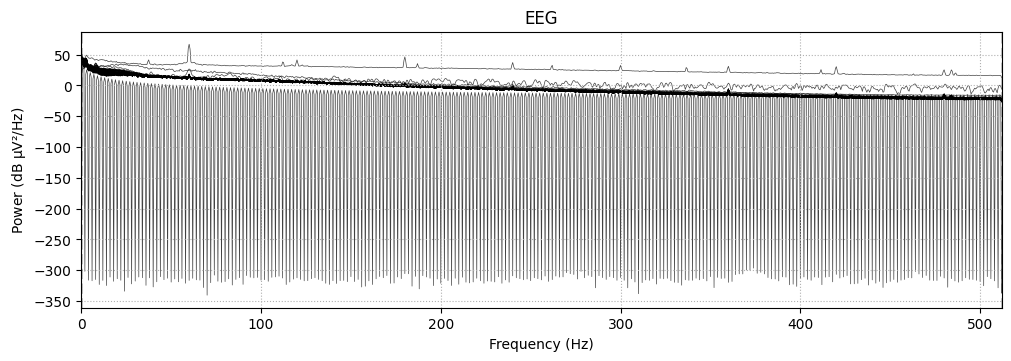

In [12]:
#Plotting the PSD of the data without the outlier channels
raw.plot_psd(picks=np.delete(np.arange(0, 105), outlier_channels), average=False)

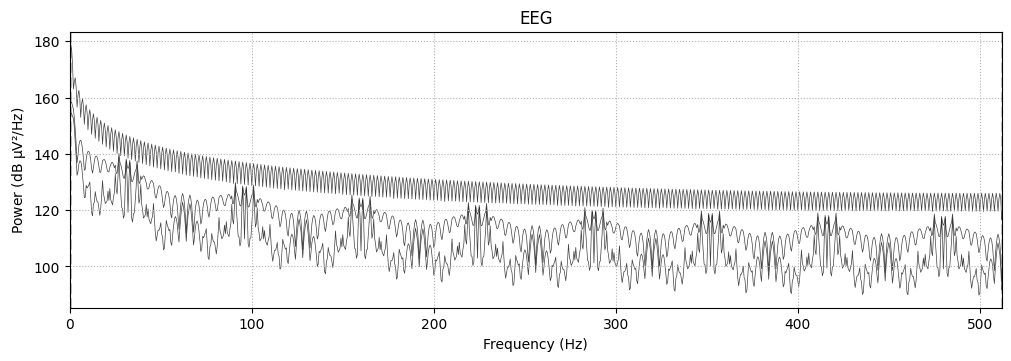

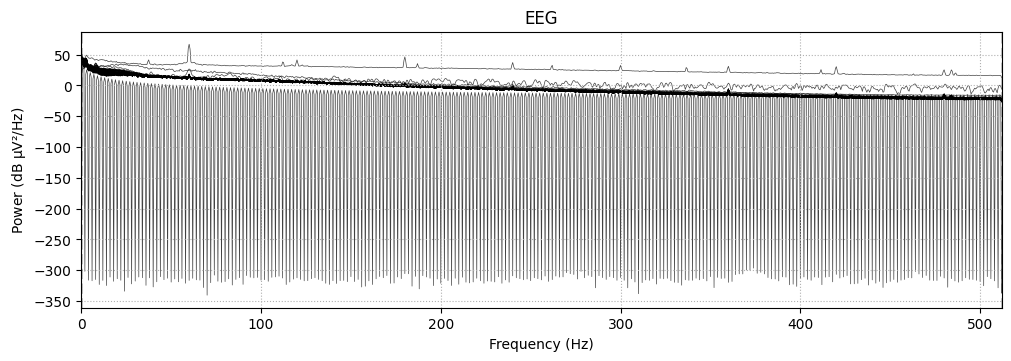

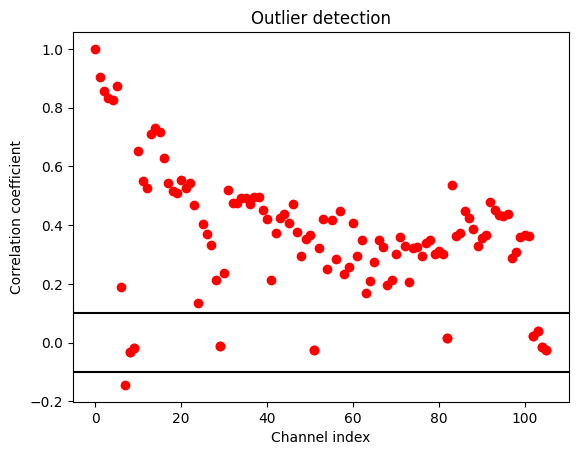

In [13]:
#Using a reference channel 
reference_channel = 'EEG 000'  
correlation_values = np.corrcoef(raw[reference_channel][0], raw.get_data())[0, 1:]
correlation_threshold = 0.1  
outlier_channels = np.where(np.abs(correlation_values) < correlation_threshold)[0]
#Plotting correlation values
fig, ax = plt.subplots()
ax.plot(correlation_values, 'ro')
ax.axhline(correlation_threshold, color='k')
ax.axhline(-correlation_threshold, color='k')
ax.set(title='Outlier detection', xlabel='Channel index', ylabel='Correlation coefficient')
ax.plot(outlier_channels, correlation_values[outlier_channels], 'r.', markersize=12)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


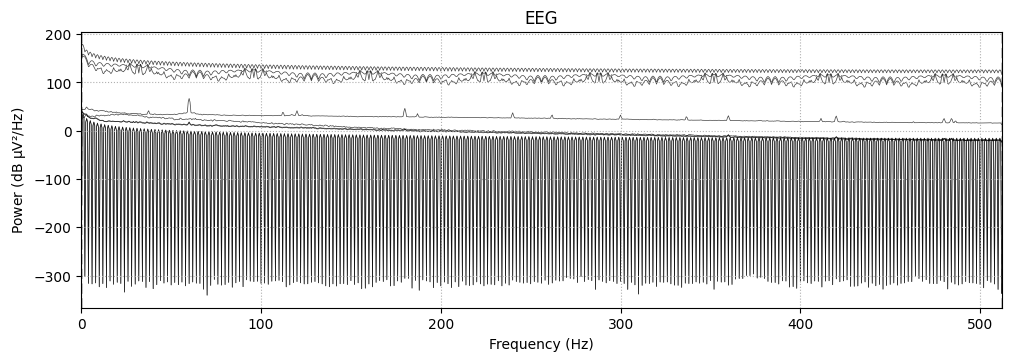

In [14]:
#Plotting the PSD of the outlier channels
raw.plot_psd(picks=outlier_channels, average=False)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


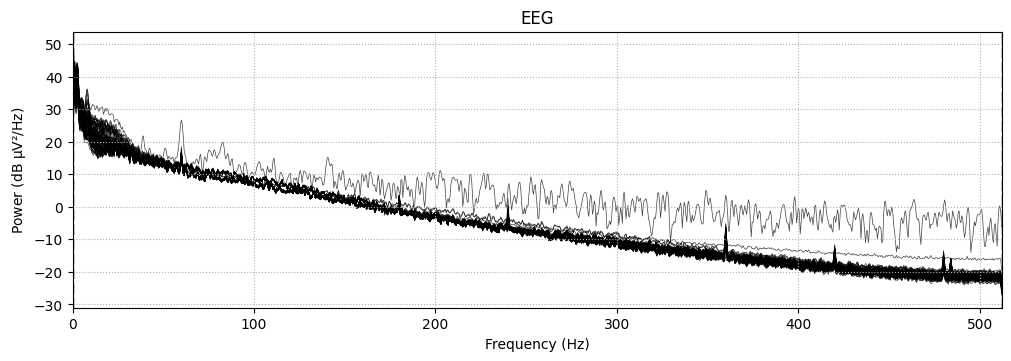

In [15]:
#Plotting the PSD of the data without the outlier channels
raw.plot_psd(picks=np.delete(np.arange(0, 106), outlier_channels), average=False)

Comment:
We have to be carefull in this data eliminaton since we dont know if we are getting riff off information 

In [13]:
#Propierties of raw 
raw.describe()

<Raw | Pat28_seizure_segment_raw.fif, 106 x 614401 (600.0 s), ~109 kB, data not loaded>
 ch  name     type  unit        min         Q1     median         Q3        max
  0  EEG 000  EEG   µV     -1653.42    -119.92       6.05     136.52    1479.98
  1  EEG 001  EEG   µV     -1649.80    -156.93      -3.32     177.73    1605.08
  2  EEG 002  EEG   µV     -1529.00    -162.11      -4.49     181.74    1632.71
  3  EEG 003  EEG   µV     -1566.02    -169.53      -7.42     187.99    1650.78
  4  EEG 004  EEG   µV     -1539.06    -168.85      -6.64     185.45    1548.24
  5  EEG 005  EEG   µV     -1615.72    -162.60      -1.76     181.05    1506.64
  6  EEG 006  EEG   µV     -1538.48     -71.78      13.67      93.85    1357.42
  7  EEG 007  EEG   µV     -1640.53     -94.63      13.18     109.77    1340.14
  8  EEG 008  EEG   µV     -1655.08     -75.20      11.82      89.75    1518.95
  9  EEG 009  EEG   µV     -1566.02     -73.44      12.30      89.55    1311.72
 10  EEG 010  EEG   µV     -1471

In [16]:
#Temporal variable to make an array with outliers channels names 
srt="EEG"
outliers_names=[]
for i in outlier_channels:
    outliers_names.append(srt+" "+str(i).zfill(3))
print(outliers_names)

['EEG 008', 'EEG 009', 'EEG 029', 'EEG 051', 'EEG 082', 'EEG 102', 'EEG 103', 'EEG 104', 'EEG 105']


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


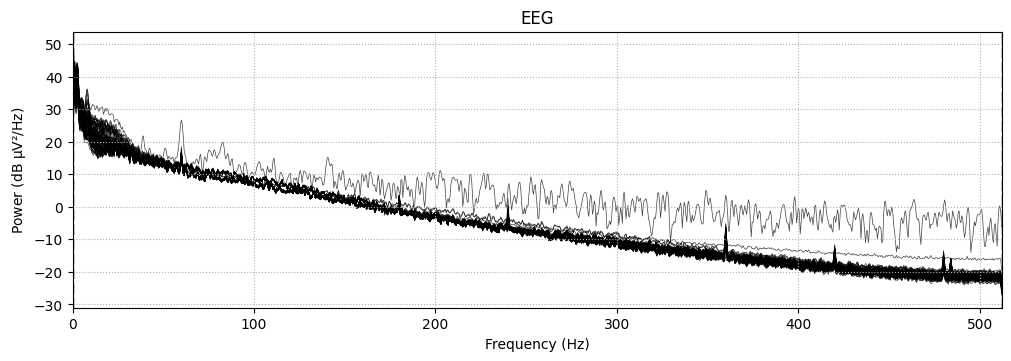

In [19]:
raw.drop_channels(outliers_names)
raw.plot_psd()

In [20]:
raw.describe()

<Raw | Pat28_seizure_segment_raw.fif, 97 x 614401 (600.0 s), ~84 kB, data not loaded>
ch  name     type  unit        min         Q1     median         Q3        max
 0  EEG 000  EEG   µV     -1653.42    -119.92       6.05     136.52    1479.98
 1  EEG 001  EEG   µV     -1649.80    -156.93      -3.32     177.73    1605.08
 2  EEG 002  EEG   µV     -1529.00    -162.11      -4.49     181.74    1632.71
 3  EEG 003  EEG   µV     -1566.02    -169.53      -7.42     187.99    1650.78
 4  EEG 004  EEG   µV     -1539.06    -168.85      -6.64     185.45    1548.24
 5  EEG 005  EEG   µV     -1615.72    -162.60      -1.76     181.05    1506.64
 6  EEG 006  EEG   µV     -1538.48     -71.78      13.67      93.85    1357.42
 7  EEG 007  EEG   µV     -1640.53     -94.63      13.18     109.77    1340.14
 8  EEG 010  EEG   µV     -1471.68     -85.35      11.23     106.84    1769.92
 9  EEG 011  EEG   µV     -1455.57     -76.66      12.21      99.51    1415.43
10  EEG 012  EEG   µV     -1469.53    -105.86

In [21]:
type(raw)

mne.io.fiff.raw.Raw

In [22]:
raw.save('pte_28_cleaned.fif', overwrite=True)

Writing /home/pablo/works/dev_thesis_SEEG/Exploration/pte_28_cleaned.fif
Closing /home/pablo/works/dev_thesis_SEEG/Exploration/pte_28_cleaned.fif
[done]


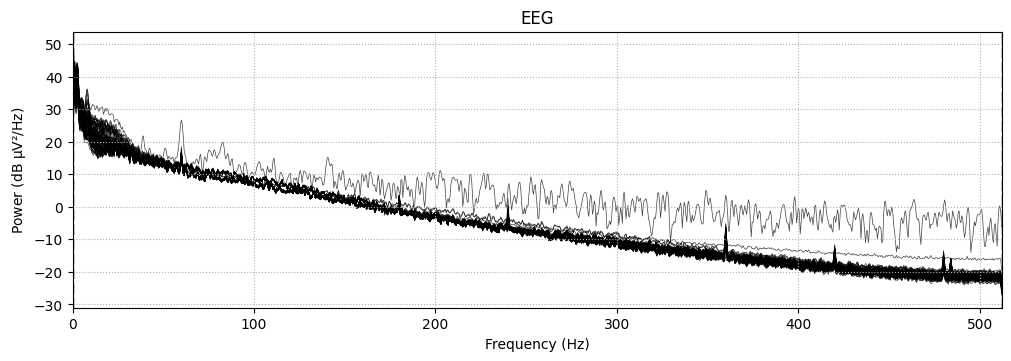

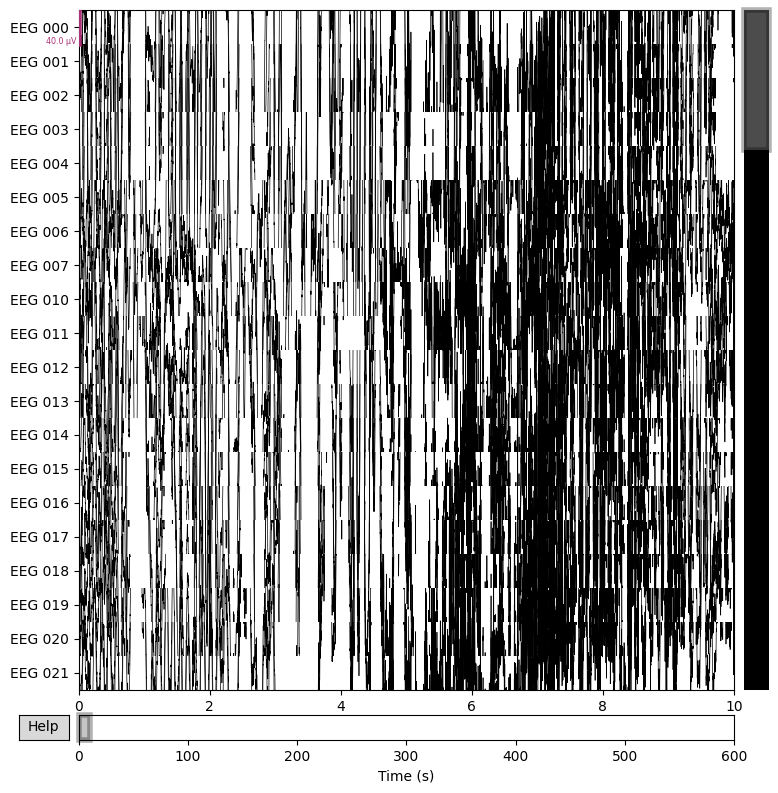

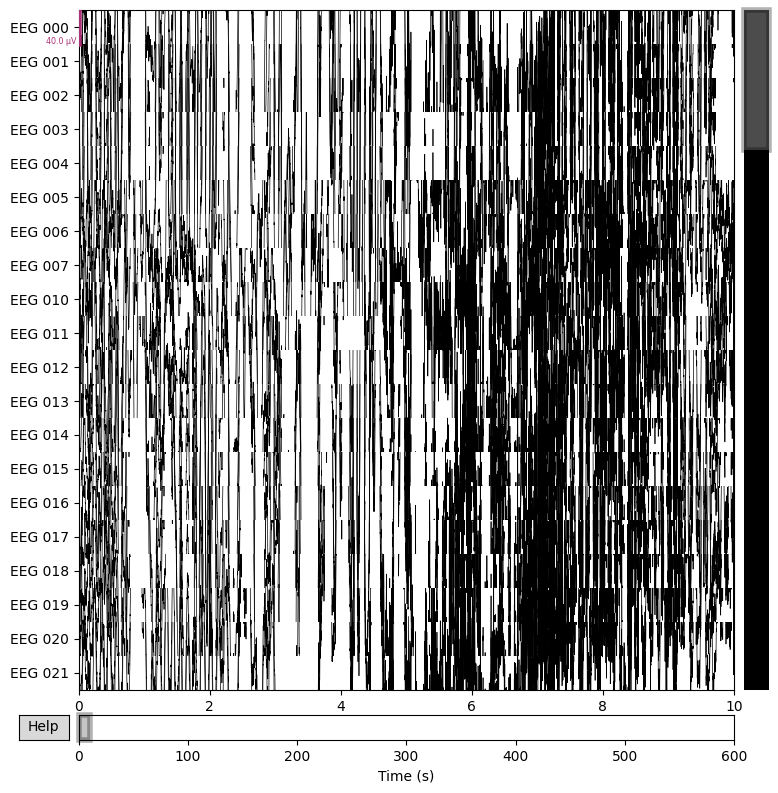

In [23]:
raw.plot()

In [18]:
#Making 3 slided windows of 200 seconds with 25% of overlap
epochs = mne.make_fixed_length_epochs(raw, duration=100, overlap=0.25,preload=True)
times=epochs.times
ch_names=epochs.ch_names

print(epochs)
print(times)
print(epochs.event_id)
print(epochs.events)

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6 events and 102400 original time points ...
0 bad epochs dropped
<Epochs |  6 events (all good), 0 – 99.999 s, baseline off, ~454.8 MB, data loaded,
 '1': 6>
[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.99970703e+01
 9.99980469e+01 9.99990234e+01]
{'1': 1}
[[6448128       0       1]
 [6550272       0       1]
 [6652416       0       1]
 [6754560       0       1]
 [6856704       0       1]
 [6958848       0       1]]


## Connectivity using VAR 
#### Kernel blow up 

In [14]:
conn = vector_auto_regression(
    data=epochs.get_data(), times=times, names=ch_names)

print(conn)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:16<00:00,  2.77s/it]

<EpochConnectivity | n_epochs : 6, , nave : 6, nodes, n_estimated : 97, 9409, ~3.6 MB>


In [15]:
predicted_data = conn.predict(epochs.get_data())

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals.
# Here we will see that because we use ordinary
# least-squares as an estimation method, the residuals
# should come with low covariances.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

: 

In [19]:
epochs.info

<Info | 9 non-empty values
 bads: []
 ch_names: EEG 000, EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
 chs: 97 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 97
 projs: []
 sfreq: 1024.0 Hz
>

##### Connectivity measures 

In [19]:
fmin, fmax = 4., 9.  # compute connectivity within 4-9 Hz
sfreq = raw.info['sfreq']  # sampling frequency
tmin = 0.0  # exclude the baseline period

# Compute PLI, wPLI, and dPLI
con_pli = spectral_connectivity_epochs(
    epochs, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

con_wpli = spectral_connectivity_epochs(
    epochs, method='wpli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

con_dpli = spectral_connectivity_epochs(
    epochs, method='dpli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 4656 connections
    using t=0.000s..99.999s for estimation (102400 points)
    frequencies: 4.0Hz..9.0Hz (501 points)
    connectivity scores will be averaged for each band


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 4656 connections
    using t=0.000s..99.999s for estimation (102400 points)
    frequencies: 4.0Hz..9.0Hz (501 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
 

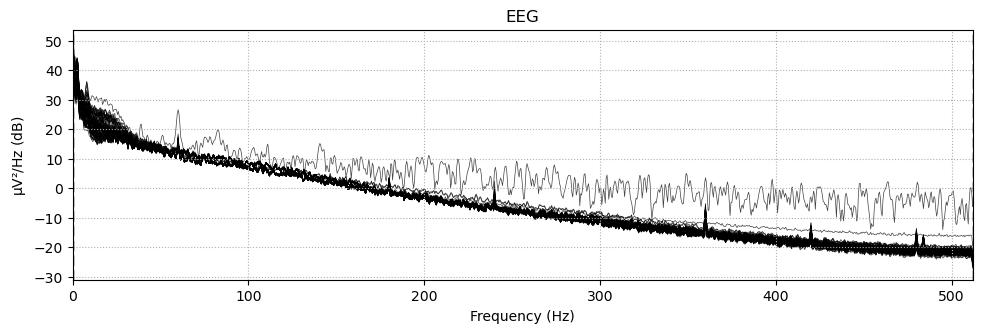

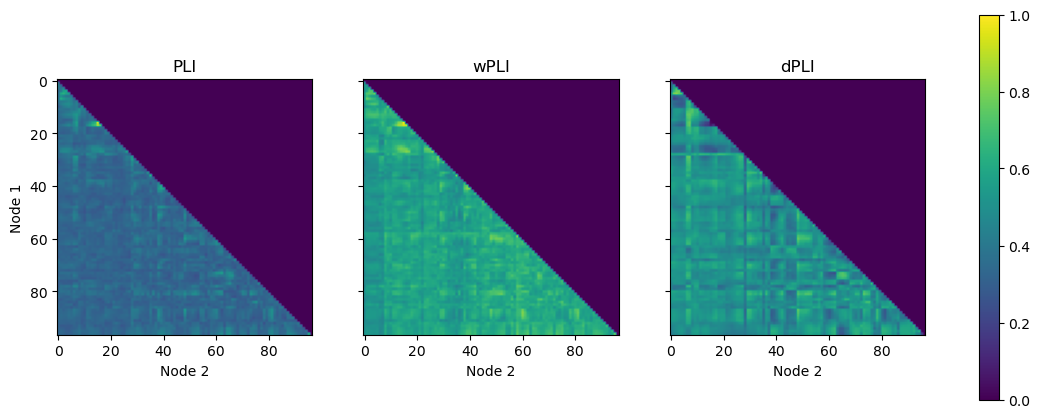

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
axs[0].imshow(con_pli.get_data('dense'), vmin=0, vmax=1)
axs[0].set_title("PLI")
axs[0].set_ylabel("Node 1")
axs[0].set_xlabel("Node 2")

axs[1].imshow(con_wpli.get_data('dense'), vmin=0, vmax=1)
axs[1].set_title("wPLI")
axs[1].set_xlabel("Node 2")

im = axs[2].imshow(con_dpli.get_data('dense'), vmin=0, vmax=1)
axs[2].set_title("dPLI")
axs[2].set_xlabel("Node 2")

fig.colorbar(im, ax=axs.ravel())
plt.show()

## Computing coherence

In [21]:
fmin = (8., 13.)
fmax = (13., 30.)
tmin = 0.0 
sfreq = raw.info['sfreq']  # the sampling frequency

coh = spectral_connectivity_epochs(
    epochs, method='coh', mode='fourier', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)
freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 4656 connections
    using t=0.000s..99.999s for estimation (102400 points)
    computing connectivity for the bands:
     band 1: 8.0Hz..13.0Hz (501 points)
     band 2: 13.0Hz..30.0Hz (1701 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1


    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Frequencies in Hz over which coherence was averaged for alpha: 
10.5
Frequencies in Hz over which coherence was averaged for beta: 
21.5


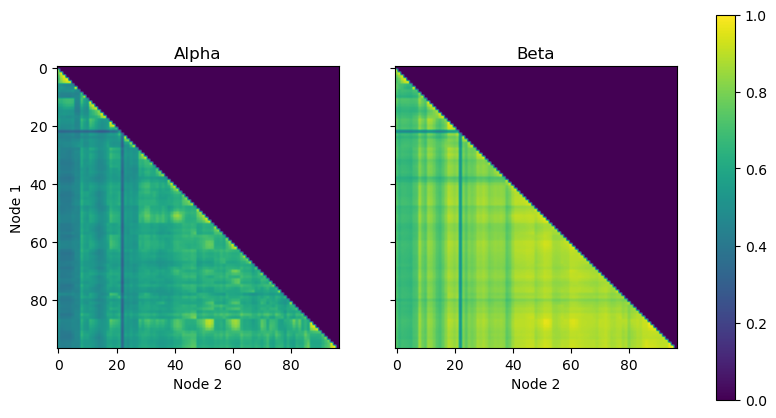

In [25]:
#Plotting coherence matrix 
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].imshow(coh.get_data('dense')[:,:,0], vmin=0, vmax=1)
axs[0].set_title("Alpha")
axs[0].set_ylabel("Node 1")
axs[0].set_xlabel("Node 2")

im = axs[1].imshow(coh.get_data('dense')[:,:,1], vmin=0, vmax=1)
axs[1].set_title("Beta")
axs[1].set_xlabel("Node 2")

fig.colorbar(im, ax=axs.ravel())
plt.show()

In [43]:
epochs_tfr = tfr_morlet(
    epochs, freqs, n_cycles=5, return_itc=False, output="complex", average=False
)

# crop either side to use a buffer to remove edge artifact
epochs_tfr.crop(tmin=-0.5, tmax=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


: 

## Applying covariance 

/tmp/ipykernel_6400/2933080643.py:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(


Computing rank from data with rank=None


/tmp/ipykernel_6400/2933080643.py:1: RuntimeWarning: Too few samples (required : 490 got : 6), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(


    Using tolerance 4.3e-12 (2.2e-16 eps * 6 dim * 3.2e+03  max singular value)
    Estimated rank (eeg): 6
    EEG: rank 6 computed from 97 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 97 -> 6


/tmp/ipykernel_6400/2933080643.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  noise_cov = mne.compute_covariance(


Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 6
log-likelihood on unseen data (descending order):
   shrunk: -63.315
   empirical: -77.589
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 4.3e-10 (2.2e-16 eps * 97 dim * 2e+04  max singular value)
    Estimated rank (eeg): 6
    EEG: rank 6 computed from 97 data channels with 0 projectors


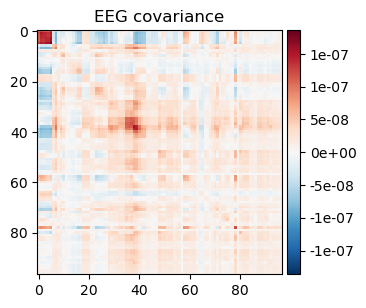

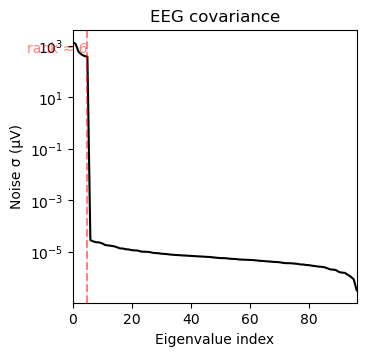

In [26]:
noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True
)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


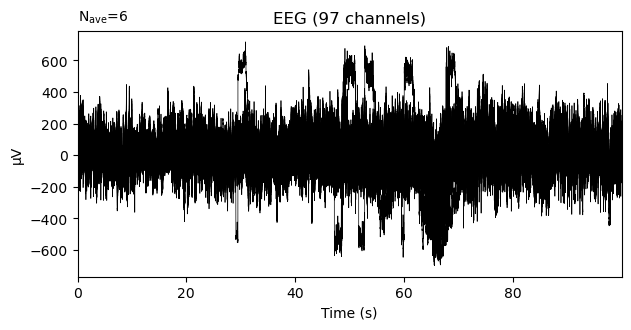

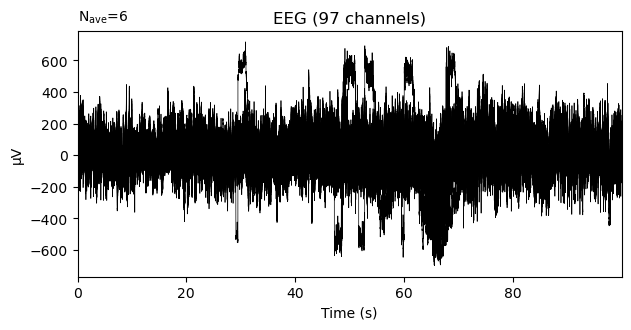

In [27]:
#Evoked response
evoked = epochs.average()
evoked.plot(time_unit='s')

In [28]:
evoked.plot_white(noise_cov, time_unit='s')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 4.3e-10 (2.2e-16 eps * 97 dim * 2e+04  max singular value)
    Estimated rank (eeg): 6
    EEG: rank 6 computed from 97 data channels with 0 projectors
Computing rank from covariance with rank={'eeg': 6}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 6 (91 small eigenvalues omitted)


/tmp/ipykernel_6400/355871161.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked.plot_white(noise_cov, time_unit='s')


: 

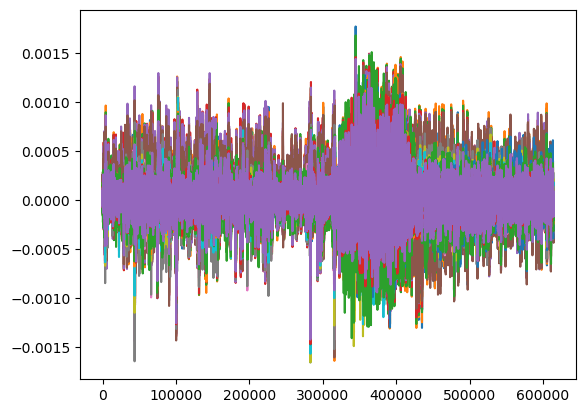

In [ ]:
#Saving the data of every channel in a list of lists
data=[]
for i in range(0, len(chanels)):
    data.append(raw.get_data(picks=chanels[i]))

#Plotting the data of every channel in the same plot
for i in range(0, 15):
    plt.plot(data[i][0])
plt.show()

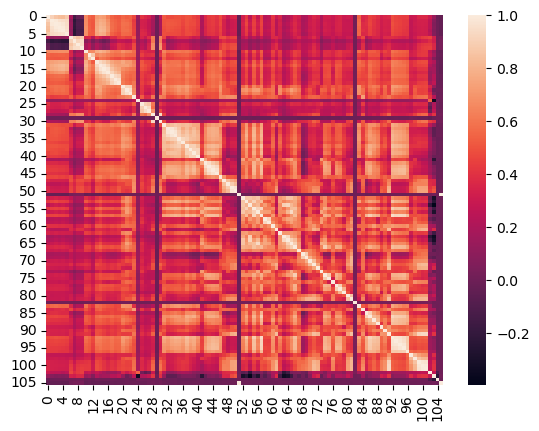

In [ ]:
#Measuring connectivity between channels
#Pearson correlation
corr=[]
for i in range(0, len(chanels)):
    for j in range(0, len(chanels)):
        corr.append(np.corrcoef(data[i][0], data[j][0])[0][1])

#Plotting the correlation matrix
corr=np.array(corr)
corr=corr.reshape(len(chanels), len(chanels))
sns.heatmap(corr)
plt.show()